# Workflow for a multi-regional energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
from getData import getData
import os
cwd = os.getcwd()
data = getData()

%matplotlib inline  
%load_ext autoreload
%autoreload 2

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = {'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$', 'biogas': r'GW$_{biogas,LHV}$',
                     'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'biogas', 'CO2'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [3]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

In [4]:
CO2_reductionTarget = 1

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [5]:
esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [6]:
data['Wind (onshore), operationRateMax'].sum()

cluster_0    1572.003960
cluster_1    2350.292663
cluster_2    2374.507270
cluster_3    2186.572278
cluster_4    1572.650655
cluster_5    1767.840650
cluster_6    2719.564564
cluster_7    1553.045964
dtype: float64

### Wind offshore

In [7]:
esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (offshore), operationRateMax'],
                  capacityMax=data['Wind (offshore), capacityMax'],
                  investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [8]:
data['Wind (offshore), operationRateMax'].sum()

cluster_0       0.000000
cluster_1    4435.420314
cluster_2    4301.655834
cluster_3    3902.391858
cluster_4       0.000000
cluster_5       0.000000
cluster_6    4609.508396
cluster_7       0.000000
dtype: float64

### PV

In [9]:
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))

Full load hours:

In [10]:
data['PV, operationRateMax'].sum()

cluster_0    1113.216464
cluster_1    1053.579422
cluster_2    1058.005181
cluster_3    1079.872237
cluster_4    1140.407380
cluster_5    1051.848141
cluster_6    1069.843344
cluster_7    1085.697466
dtype: float64

### Exisisting run-of-river hydroelectricity plants

In [11]:
esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                  hasCapacityVariable=True,
                  operationRateFix=data['Existing run-of-river plants, operationRateFix'], tsaWeight=0.01,
                  capacityFix=data['Existing run-of-river plants, capacityFix'],
                  investPerCapacity=0, opexPerCapacity=0.208))

## 3.2. Methane (natural gas and biogas)

### Natural gas

In [12]:
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCost=0.0331*1e-3))

### Biogas

In [13]:
esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas',
                  operationRateMax=data['Biogas, operationRateMax'], hasCapacityVariable=False,
                  commodityCost=0.05409*1e-3))

## 3.3 CO2

### CO2

The CO2 source is required for the case in which it can be mixed with conventional natural gas.

In [14]:
esM.add(fn.Source(esM=esM, name='CO2 from enviroment', commodity='CO2',
                  hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

In [15]:
esM.add(fn.Conversion(esM=esM, name='CCGT plants (methane)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'methane':-1/0.625, 'CO2':201*1e-6/0.625},
                      hasCapacityVariable=True,
                      investPerCapacity=0.65, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycle gas turbine plants for biogas

In [16]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'biogas':-1/0.635},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycly gas turbines for hydrogen

In [17]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

In [18]:
esM.add(fn.Conversion(esM=esM, name='Electroylzers', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

### rSOC

In [19]:
capexRSOC=1.5

esM.add(fn.Conversion(esM=esM, name='rSOEC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

esM.add(fn.Conversion(esM=esM, name='rSOFC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [20]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [21]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))

## 5.3. Methane storage

### Methane filled salt caverns

In [22]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (biogas)', commodity='biogas',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=443,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (methane), capacityMax'],
                   investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
                   economicLifetime=30))

## 5.4 Pumped hydro storage

### Pumped hydro storage

In [23]:
esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
                   chargeEfficiency=0.88, dischargeEfficiency=0.88,
                   hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
                   chargeRate=0.16, dischargeRate=0.12, capacityFix=data['Pumped hydro storage, capacityFix'],
                   investPerCapacity=0, opexPerCapacity=0.000153))

# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

In [24]:
esM.add(fn.Transmission(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix']))

The distances of a component are set to a normalized value of 1.


### DC cables

In [25]:
esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
                        distances=data['DC cables, distances'],
                        hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))

## 6.2 Methane transmission

### Methane pipeline

In [26]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (biogas)', commodity='biogas', 
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000037, investIfBuilt=0.000314,
                        interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipelines (methane)')._mapC['cluster_0_cluster_4'][1]

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [27]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000177, investIfBuilt=0.00033,
                        interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipeline (hydrogen)')._mapC

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [28]:
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [29]:
FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [30]:
esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

#### All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, there are two ways to accomplish that:
(i) Spatial aggregation: Reducing the spatial resolution of the entire esM. 

(ii) Temporal aggregation: The time series data of the specified components can be clustered before the optimization. (The parameter timeSeriesAggregation is set to True in the optimize call if temporal aggregation is performed.)

# 8.1 Spatial Aggregation

In [31]:
from FINE.IOManagement import xarray_io as xrio
import geopandas as gpd

In [32]:
shapefile = 'InputData/SpatialData/ShapeFiles/clusteredRegions.shp'
regions_gdf = gpd.read_file(shapefile)


Performing distance-based clustering on the regions. Clustering mode: sklearn_hierarchical
Statistics on this hiearchical clustering:
The cophenetic correlation coefficient is  0.6412997116997836


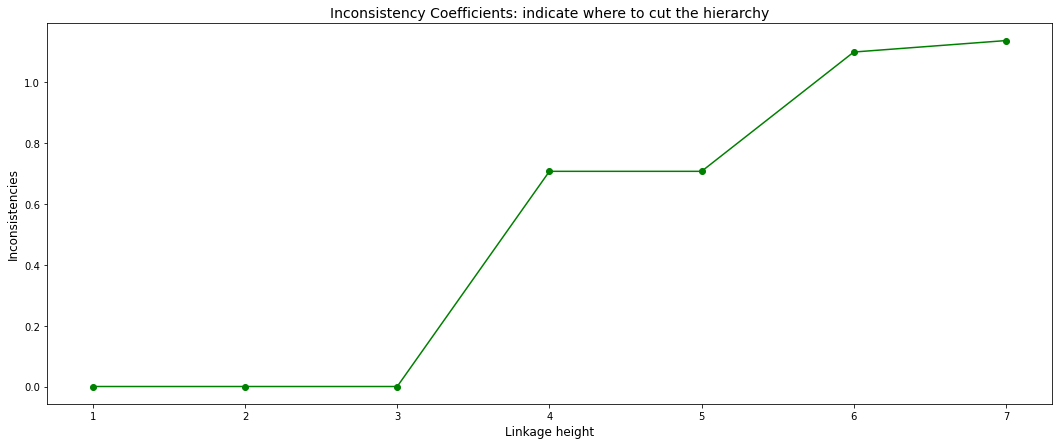

elapsed time for distance_based_clustering: 0.00 minutes
Aggregation mode for 2d_locationalEligibility set to bool as only binary values are acceptable for this variable
Aggregation mode for 1d_locationalEligibility set to bool as only binary values are acceptable for this variable
elapsed time for save_sds: 0.01 minutes


In [33]:
aggregated_esM = xrio.spatial_aggregation(esM, 
                                    gdfRegions = regions_gdf, 
                                    grouping_mode = 'distance_based',
                                    nRegionsForRepresentation = 3,
                                    aggregatedResultsPath='OutputData') 

In [34]:
aggregated_esM.locations

{'cluster_0_cluster_4_cluster_7',
 'cluster_1_cluster_2_cluster_6',
 'cluster_3_cluster_5'}

In [35]:
aggregated_esM.componentModelingDict['TransmissionModel'].componentsDict

{'AC cables': <FINE.transmission.Transmission at 0x26b4885ec48>,
 'DC cables': <FINE.transmission.Transmission at 0x26b48788848>,
 'Pipelines (biogas)': <FINE.transmission.Transmission at 0x26b4879c088>,
 'Pipelines (hydrogen)': <FINE.transmission.Transmission at 0x26b4879cf08>}

# 8.2 Temporal Aggregation

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [36]:
aggregated_esM.cluster(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...
		(5.4298 sec)



# 9 Optimization

In [37]:
aggregated_esM.optimize(timeSeriesAggregation=True, solver='OptimalityTol=1e-3 method=2 cuts=0')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3110 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2025 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.1140 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2698 sec)

Declaring shared potential constraint...
		(0.0015 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.3819 sec)

Declaring objective function...
		(0.1583 sec)

    cuts=0': Failed to set executable for solver asl. File with
    name=Opti

# 10. Selected Results Output

## 10.1. Plots for Spatial Aggregation Results 

#### Original spatial resolution

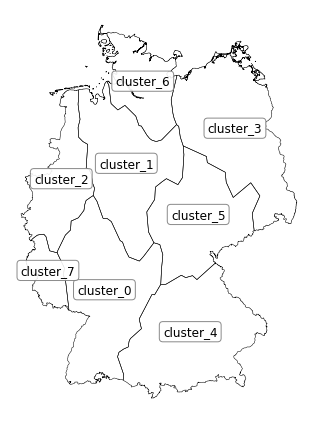

In [38]:
locFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'clusteredRegions.shp')
fig, ax = fn.plotLocations(locFilePath, plotLocNames=True, indexColumn='index')

#### Spatial resolution after aggregation

In [ ]:
aggregated_regions_FilePath = os.path.join(cwd, 'OutputData', 'sds_regions.shp')
fig, ax = fn.plotLocations(aggregated_regions_FilePath, plotLocNames=True, indexColumn='space')

## 10.2. Sources and Sink Optimization Summary

In [ ]:
aggregated_esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

#### Plot installed capacities

In [ ]:
## 'Wind (onshore)'
fig, ax = fn.plotLocationalColorMap(aggregated_esM, 
                                    'Wind (onshore)', 
                                    aggregated_regions_FilePath, 
                                    'space', 
                                    perArea=True)

In [ ]:
## 'PV'
fig, ax = fn.plotLocationalColorMap(aggregated_esM, 
                                    'PV', 
                                    aggregated_regions_FilePath, 
                                    'space', 
                                    perArea=True)

#### Plot operation time series (either one or two dimensional)

In [ ]:
fig, ax = fn.plotOperation(aggregated_esM, 
                           'Electricity demand', 
                           'cluster_1_cluster_2_cluster_6')

## 10.2. Conversion Optimization Summary

In [ ]:
aggregated_esM.getOptimizationSummary("ConversionModel", outputLevel=2)

In [ ]:
fig, ax = fn.plotOperationColorMap(aggregated_esM, 
                                   'New CCGT plants (biogas)', 
                                   'cluster_1_cluster_2_cluster_6')

## 10.3. Storage Optimization Summary

In [ ]:
aggregated_esM.getOptimizationSummary("StorageModel", outputLevel=2)

In [ ]:
fig, ax = fn.plotOperationColorMap(aggregated_esM, 
                                   'Li-ion batteries', 
                                   'cluster_1_cluster_2_cluster_6', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

In [ ]:
fig, ax = fn.plotOperationColorMap(aggregated_esM, 
                                   'Pumped hydro storage', 
                                   'cluster_1_cluster_2_cluster_6',
                                  variableName='stateOfChargeOperationVariablesOptimum')

In [ ]:
fig, ax = fn.plotOperationColorMap(aggregated_esM, 
                                   'Salt caverns (biogas)', 
                                   'cluster_1_cluster_2_cluster_6',
                                  variableName='stateOfChargeOperationVariablesOptimum')

In [ ]:
fig, ax = fn.plotOperationColorMap(aggregated_esM, 
                                   'Salt caverns (hydrogen)', 
                                   'cluster_1_cluster_2_cluster_6',
                                  variableName='stateOfChargeOperationVariablesOptimum')

## 10.4. Transmission Optimization Summary

In [ ]:
#TODO: check why 'Pipelines' are not present here (they are present after spatial aggregation)
aggregated_esM.getOptimizationSummary("TransmissionModel", outputLevel=2)

Check that the shared capacity of the pipelines are not exceeded

In [ ]:
df=esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc['Pipelines (biogas)']+df.loc['Pipelines (hydrogen)']

In [ ]:
#TODO: check TODO in create_grid_shapefile (representation.py) and in save_sds (dataset.py), work on it, save grid shapefiles during 
# spatial aggregation and then run the cells below 

In [39]:
ac_lines_shp = gpd.read_file('C:/Users/s.patil/Documents/code/fine/test/spagat/data/output/test_ac_lines.shp')

<AxesSubplot:>

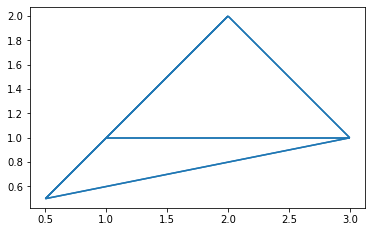

In [41]:
ac_lines_shp.plot()

In [ ]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'AClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'AC cables', transFilePath, loc0='bus0', loc1='bus1', fig=fig, ax=ax)

In [ ]:
fig, ax = fn.plotLocations(aggregated_regions_FilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM_aggregated, 'AC cables', aggregated_grid_FilePath, loc0='bus0', loc1='bus1', fig=fig, ax=ax)

In [ ]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'DClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'DC cables', transFilePath, loc0='cluster0', loc1='cluster1', fig=fig, ax=ax)

In [ ]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (hydrogen)', transFilePath, loc0='cluster0', loc1='cluster1',
                              fig=fig, ax=ax)

In [ ]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (biogas)', transFilePath, loc0='cluster0', loc1='cluster1',
                              fig=fig, ax=ax)